### 📊 Descripción de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa

#### 💾 Carga de Data Set

In [2]:
energy_df = pd.read_parquet('../data/interim/energy_modify_dataset.parquet', engine='pyarrow')

In [4]:
energy_df['CLIENTE'].cat.categories

Index(['C-2', 'C-3', 'C-4', 'C-5', 'C-R'], dtype='object')

### ✂️ Dividir data set, entrenamiento / test

Calculamos fecha de corte de los datos

In [6]:
# Fecha inicial y final de tus datos
init_date = energy_df['Fecha HR'].min()
final_date = energy_df['Fecha HR'].max()


# Calcular la duración total en días
total_duration = final_date - init_date

# Calcular el 80% de la duración total
duration_80_percent = total_duration * 0.8

# Calcular la fecha de corte
cut_date = init_date + duration_80_percent

print("Fecha de corte para dividir los datos:", cut_date)

Fecha de corte para dividir los datos: 2017-01-11 19:08:00


In [13]:
cut_date = '2017-01-11 19:00:00'
train = energy_df.query( "`Fecha HR` < @cut_date" ).copy()
test = energy_df.query( "`Fecha HR` >= @cut_date" ).copy()

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455027 entries, 0 to 546274
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   kWh E     455027 non-null  float64       
 1   Fecha HR  455027 non-null  datetime64[ns]
 2   CLIENTE   455027 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 10.8 MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114060 entries, 90948 to 569086
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   kWh E     114060 non-null  float64       
 1   Fecha HR  114060 non-null  datetime64[ns]
 2   CLIENTE   114060 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 2.7 MB


In [28]:
energy_df['CLIENTE'].value_counts()

CLIENTE
C-R    114047
C-2    113760
C-3    113760
C-4    113760
C-5    113760
Name: count, dtype: int64

In [27]:
train['CLIENTE'].value_counts()

CLIENTE
C-R    91235
C-2    90948
C-3    90948
C-4    90948
C-5    90948
Name: count, dtype: int64

In [29]:
test['CLIENTE'].value_counts()

CLIENTE
C-2    22812
C-3    22812
C-4    22812
C-5    22812
C-R    22812
Name: count, dtype: int64

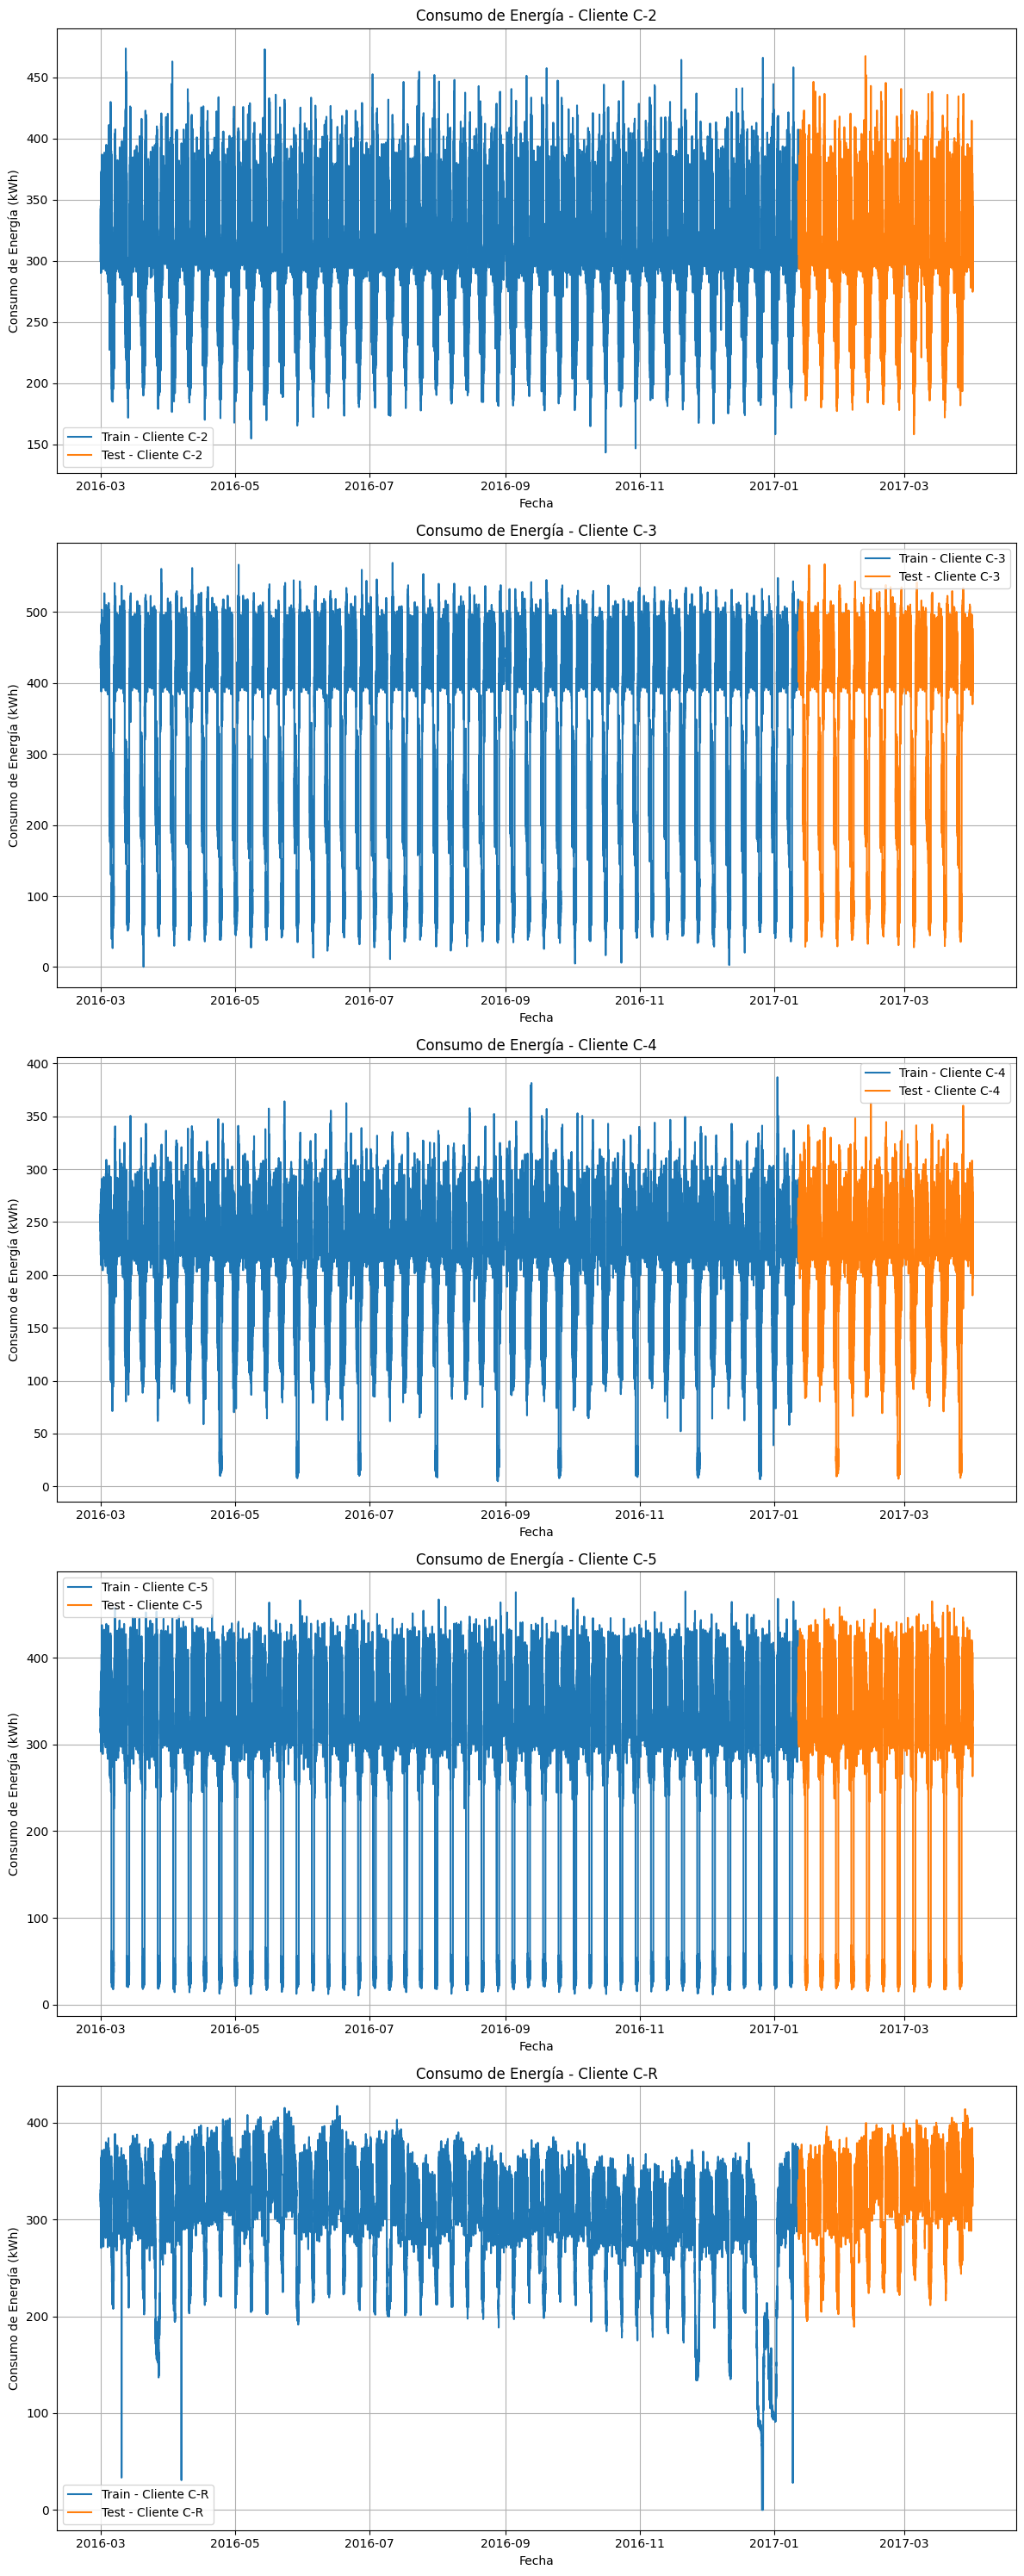

In [32]:
# Obtener los clientes únicos
clientes = energy_df['CLIENTE'].unique()

# Configurar el gráfico
fig, axs = plt.subplots(len(clientes), figsize=(12, 6*len(clientes)))

# Iterar sobre cada cliente y graficar los datos de entrenamiento y prueba
for i, cliente in enumerate(clientes):
    # Datos de entrenamiento para el cliente actual
    train_cliente = train[train['CLIENTE'] == cliente]
    axs[i].plot(train_cliente['Fecha HR'], train_cliente['kWh E'], label=f'Train - Cliente {cliente}')

    # Datos de prueba para el cliente actual
    test_cliente = test[test['CLIENTE'] == cliente]
    axs[i].plot(test_cliente['Fecha HR'], test_cliente['kWh E'], label=f'Test - Cliente {cliente}')

    # Añadir leyenda y etiquetas
    axs[i].set_title(f'Consumo de Energía - Cliente {cliente}')
    axs[i].set_xlabel('Fecha')
    axs[i].set_ylabel('Consumo de Energía (kWh)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


#### 💾 Guardar nuevo Data Set

In [21]:
train.reset_index(drop=True, inplace=True)  # Reset index
schema1 = pa.Table.from_pandas(train).schema
train.to_parquet( '../data/processed/train_dataset.parquet',
                    index=False,
                    schema=schema1
)

test.reset_index(drop=True, inplace=True)  # Reset index
schema2 = pa.Table.from_pandas(test).schema
test.to_parquet( '../data/processed/test_dataset.parquet',
                    index=False,
                    schema=schema2
)